In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv("artifacts/workData/df.csv", index_col=0)
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,img_0,0,0,0,1
1,img_1,0,1,0,0
2,img_2,1,0,0,0
3,img_3,0,0,1,0
4,img_4,1,0,0,0


In [35]:
df.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [6]:
df.dtypes

image_id             object
healthy               int64
multiple_diseases     int64
rust                  int64
scab                  int64
dtype: object

In [7]:
df.isna().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

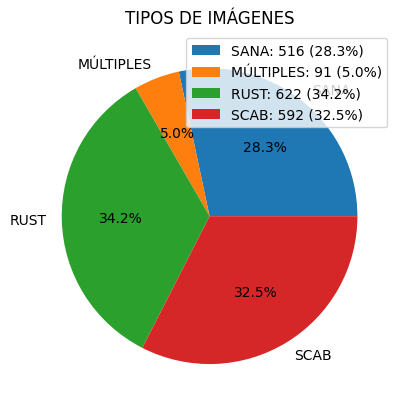

In [10]:
import matplotlib.pyplot as plt

df = pd.read_csv("artifacts/sourceData/train.csv")

healthy = df[df.healthy == 1]
mult = df[df.multiple_diseases == 1]
rust = df[df.rust == 1]
scab = df[df.scab == 1]

#Cuenta la cantidad de imagénes de cada enfermedad
valores = [len(healthy), len(mult), len(rust), len(scab)]
etiquetas = ['SANA', 'MÚLTIPLES', 'RUST', 'SCAB']

# Crear el gráfico
plt.pie(valores, labels=etiquetas, autopct='%1.1f%%')
plt.title('TIPOS DE IMÁGENES')
plt.legend(labels=['{}: {} ({:.1f}%)'.format(etiqueta, valor, (valor/sum(valores))*100) for etiqueta, valor in zip(etiquetas, valores)])
plt.show()

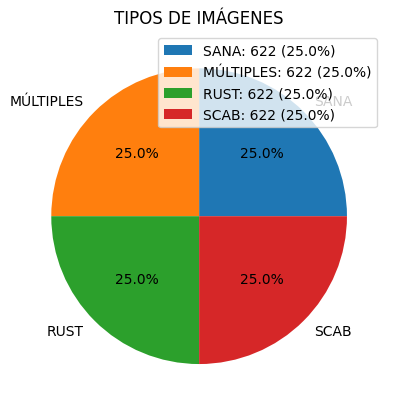

In [11]:
import matplotlib.pyplot as plt

df = pd.read_csv("artifacts/workData/df.csv")

healthy = df[df.healthy == 1]
mult = df[df.multiple_diseases == 1]
rust = df[df.rust == 1]
scab = df[df.scab == 1]

#Cuenta la cantidad de imagénes de cada enfermedad
valores = [len(healthy), len(mult), len(rust), len(scab)]
etiquetas = ['SANA', 'MÚLTIPLES', 'RUST', 'SCAB']

# Crear el gráfico
plt.pie(valores, labels=etiquetas, autopct='%1.1f%%')
plt.title('TIPOS DE IMÁGENES')
plt.legend(labels=['{}: {} ({:.1f}%)'.format(etiqueta, valor, (valor/sum(valores))*100) for etiqueta, valor in zip(etiquetas, valores)])
plt.show()

Es un dataset desbalanceado. Vamos a igualar los datos por imágenes.

In [13]:
from PIL import Image, ImageOps

In [15]:
def random_transformation(image):
    import random
    from PIL import ImageEnhance

    """Apply a random transformation to an image."""
    choice = random.randint(1, 4)
    if choice == 1:
        # Rotate the image by a random angle
        return image.rotate(random.randint(-30, 30))
    elif choice == 2:
        # Flip the image horizontally
        return ImageOps.mirror(image)
    elif choice == 3:
        # Enhance or change the contrast randomly
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(random.uniform(0.5, 1.5))
    elif choice == 4:
        # Scale the image
        scale = random.uniform(0.5, 1.5)
        width, height = image.size
        return image.resize((int(width * scale), int(height * scale)))

In [18]:
path = "artifacts\images\Test_103.jpg"
with Image.open(path) as img :
    new_img = random_transformation(img)
    new_img.show()

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import random
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

class DataAugmentation :
    def __init__(self, df: pd.DataFrame, imgs_path: Path) -> None:
        self.df = df
        self.imgs_path = imgs_path

    def main(self) :
        separated_dfs = {
            "healthy" : self.df[self.df.healthy == 1],
            "multiple_diseases" : self.df[self.df.multiple_diseases == 1],
            "rust" : self.df[self.df.rust == 1],
            "scab" : self.df[self.df.scab == 1]
        }

        goal_amount = max([len(df) for df in separated_dfs.values()])

        last_index = len(self.df)
        for col in self.df.columns[1:] :
            iterations = goal_amount - len(separated_dfs[col])
            while iterations > 0 :
                img_id = random.choice(list(separated_dfs[col]['image_id']))
                with Image.open(f"{self.imgs_path}/{img_id}.jpg") as img :
                    new_img = self.random_transformation(img)
                    new_img_id = f"Train_{last_index}"
                    new_img_path = f"{self.imgs_path}/{new_img_id}.jpg"
                    new_img.save(new_img_path)

                row = {'image_id': new_img_id, 'healthy': 0, 'multiple_diseases': 0, 'rust': 0, 'scab': 0}
                row[col] = 1
                
                new_row_df = pd.DataFrame([row])

                # Use concat to add the new row to the DataFrame
                self.df = pd.concat([self.df, new_row_df], ignore_index=True)

                last_index += 1
                iterations -= 1

        self.df.to_csv("artifacts/new_df.csv")

        return True
    
    def random_transformation(self, image: Image) -> Image :
        """Apply a single random transformation to an image."""
        transformations = [
            lambda x: x.rotate(random.randint(-30, 30), expand=True),  # Rotation
            ImageOps.mirror,                                          # Horizontal Flip
            lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.5, 1.5)),  # Contrast Adjustment
            lambda x: x.resize((int(x.width * random.uniform(0.7, 1.3)), int(x.height * random.uniform(0.7, 1.3)))),  # Scaling
            ImageOps.flip,                                            # Vertical Flip
            lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.5, 1.5)),  # Brightness Adjustment
            lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.5, 1.5)),  # Color Jitter
            lambda x: ImageEnhance.Sharpness(x).enhance(random.uniform(0.5, 2.0)),  # Sharpness Enhancement
            lambda x: self.add_gaussian_noise(x),                          # Gaussian Noise
            lambda x: self.crop_and_resize(x)                              # Crop and Resize
        ]
        # Apply a single random transformation
        transformation = random.choice(transformations)
        return transformation(image)

    def add_gaussian_noise(self, image):
        """Add Gaussian noise to an image."""
        np_image = np.array(image)
        row, col, ch = np_image.shape
        mean = 0
        sigma = random.uniform(1, 25)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch).astype('uint8')
        noisy = np_image + gauss
        return Image.fromarray(np.clip(noisy, 0, 255).astype('uint8'))

    def crop_and_resize(self, image):
        """Crop the image randomly and resize it back to original dimensions."""
        original_size = image.size
        left = random.randint(0, original_size[0] // 4)
        top = random.randint(0, original_size[1] // 4)
        right = random.randint(3 * original_size[0] // 4, original_size[0])
        bottom = random.randint(3 * original_size[1] // 4, original_size[1])
        image = image.crop((left, top, right, bottom))
        return image.resize(original_size)
    
data_augmentation = DataAugmentation(df=df[:50], imgs_path="artifacts/images")
data_augmentation.main()

True

KeyError: 1

In [29]:
separated_dfs = {
    "healthy" : df[df.healthy == 1],
    "multiple_diseases" : df[df.multiple_diseases == 1],
    "rust" : df[df.rust == 1],
    "scab" : df[df.scab == 1]
}

In [32]:
random.choice(separated_dfs["healthy"])

NameError: name 'choice' is not defined

In [33]:
import random 

random.choice(df)

KeyError: 827

In [24]:
len(df)

1821

In [22]:
data_augmentation = DataAugmentation(df=df, imgs_path="artifacts/images")
data_augmentation.main()

622